Imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

Einlesen CSV-Datei

In [84]:
df = pd.read_csv('telco_churn.csv', index_col=0, sep = ';')
df.drop(columns = 'Count', inplace = True)
df.head()

,Country,State,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Score,CLTV
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,United States,California,NaN,NaN,"33,964131","-118,272783",Male,No,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,"53,85","108,15",86.0,3239.0
9237-HQITU,United States,California,Los Angeles,90005.0,"34,059281","-118,307420",Female,No,No,Yes,...,No,NaN,No,Month-to-month,Yes,Electronic check,"70,7","151,65",NaN,2701.0
9305-CDSKC,United States,California,Los Angeles,90006.0,"34,048013","-118,293953",Female,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,"99,65","820,5",86.0,5372.0
7892-POOKP,United States,California,Los Angeles,90010.0,"34,062125","-118,315709",Female,No,Yes,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,"104,8","3046,05",84.0,5003.0
0280-XJGEX,United States,California,Los Angeles,90015.0,"34,039224","-118,266293",Male,No,No,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),"103,7","5036,3",89.0,NaN


Datentyp zu 'Categorical' geändert, wenn angebracht.
Zip Code, Tenure Months, Monthly Charges und Total Charges zu 'Float' geändert, um die Verarbeitung zu erleichtern.
Latitude und Longitude bleiben 'Object', da 'Integer' oder 'Float' hier nicht weiterhilft.

In [85]:
df.Country = df.Country.astype('category')
df.State = df.State.astype('category')
df.City = df.City.astype('category')
cols = []
for i in range(6,23):
    cols.append(df.columns[i])
    for col in cols:
        df[col] = df[col].astype('category')
df['Monthly Charges'] = df['Monthly Charges'].str.replace(',','.').str.replace(' ','').astype('float64')
df['Total Charges'] = df['Total Charges'].str.replace(',','.').str.replace(' ','0').astype('float64')
df.Latitude = df.Latitude.str.replace(',','.').astype('object')
df.Longitude = df.Longitude.str.replace(',','.').astype('object')

df['Tenure Months'] = df['Tenure Months'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Country            7043 non-null   category
 1   State              6001 non-null   category
 2   City               6237 non-null   category
 3   Zip Code           5986 non-null   float64 
 4   Latitude           6081 non-null   object  
 5   Longitude          6390 non-null   object  
 6   Gender             7043 non-null   category
 7   Senior Citizen     7043 non-null   category
 8   Partner            7043 non-null   category
 9   Dependents         7043 non-null   category
 10  Tenure Months      5900 non-null   float64 
 11  Phone Service      7043 non-null   category
 12  Multiple Lines     7043 non-null   category
 13  Internet Service   6313 non-null   category
 14  Online Security    7043 non-null   category
 15  Online Backup      7043 non-null   category
 

Visualisierung der relevanten Variablen.

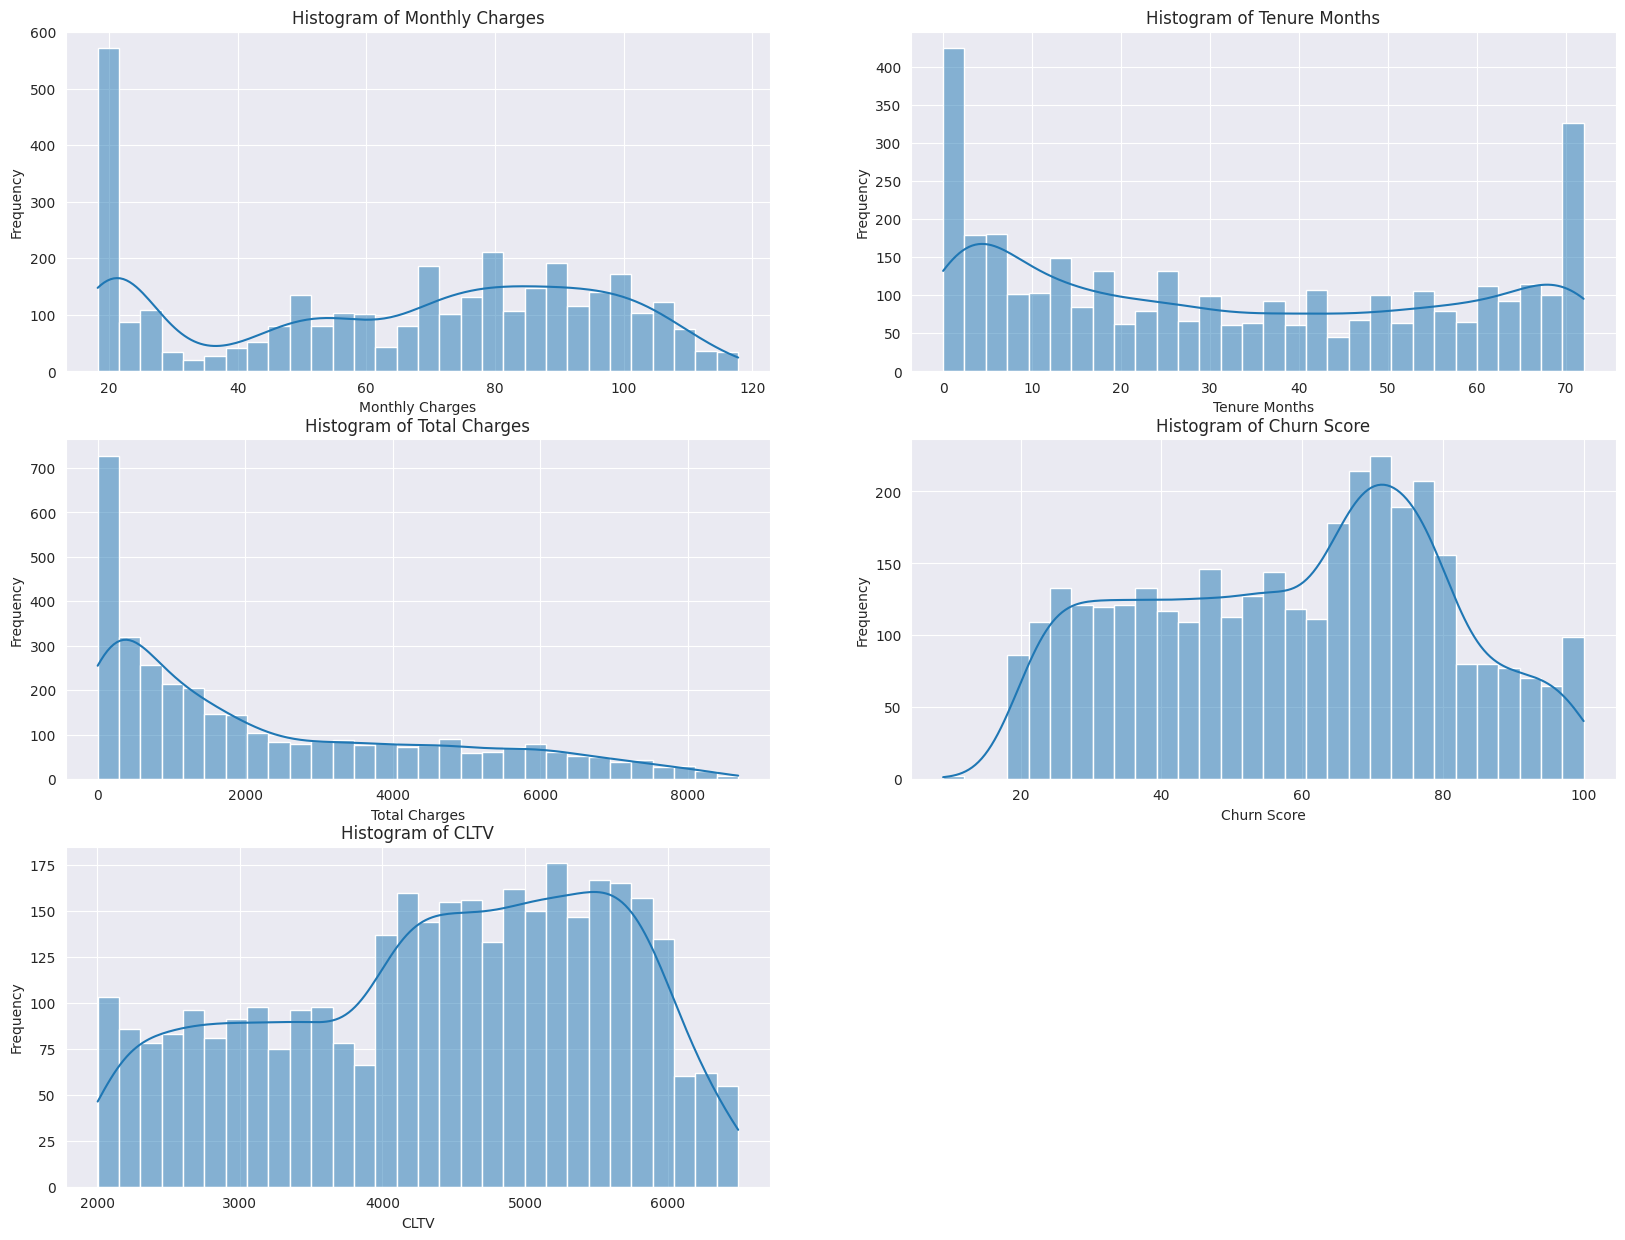

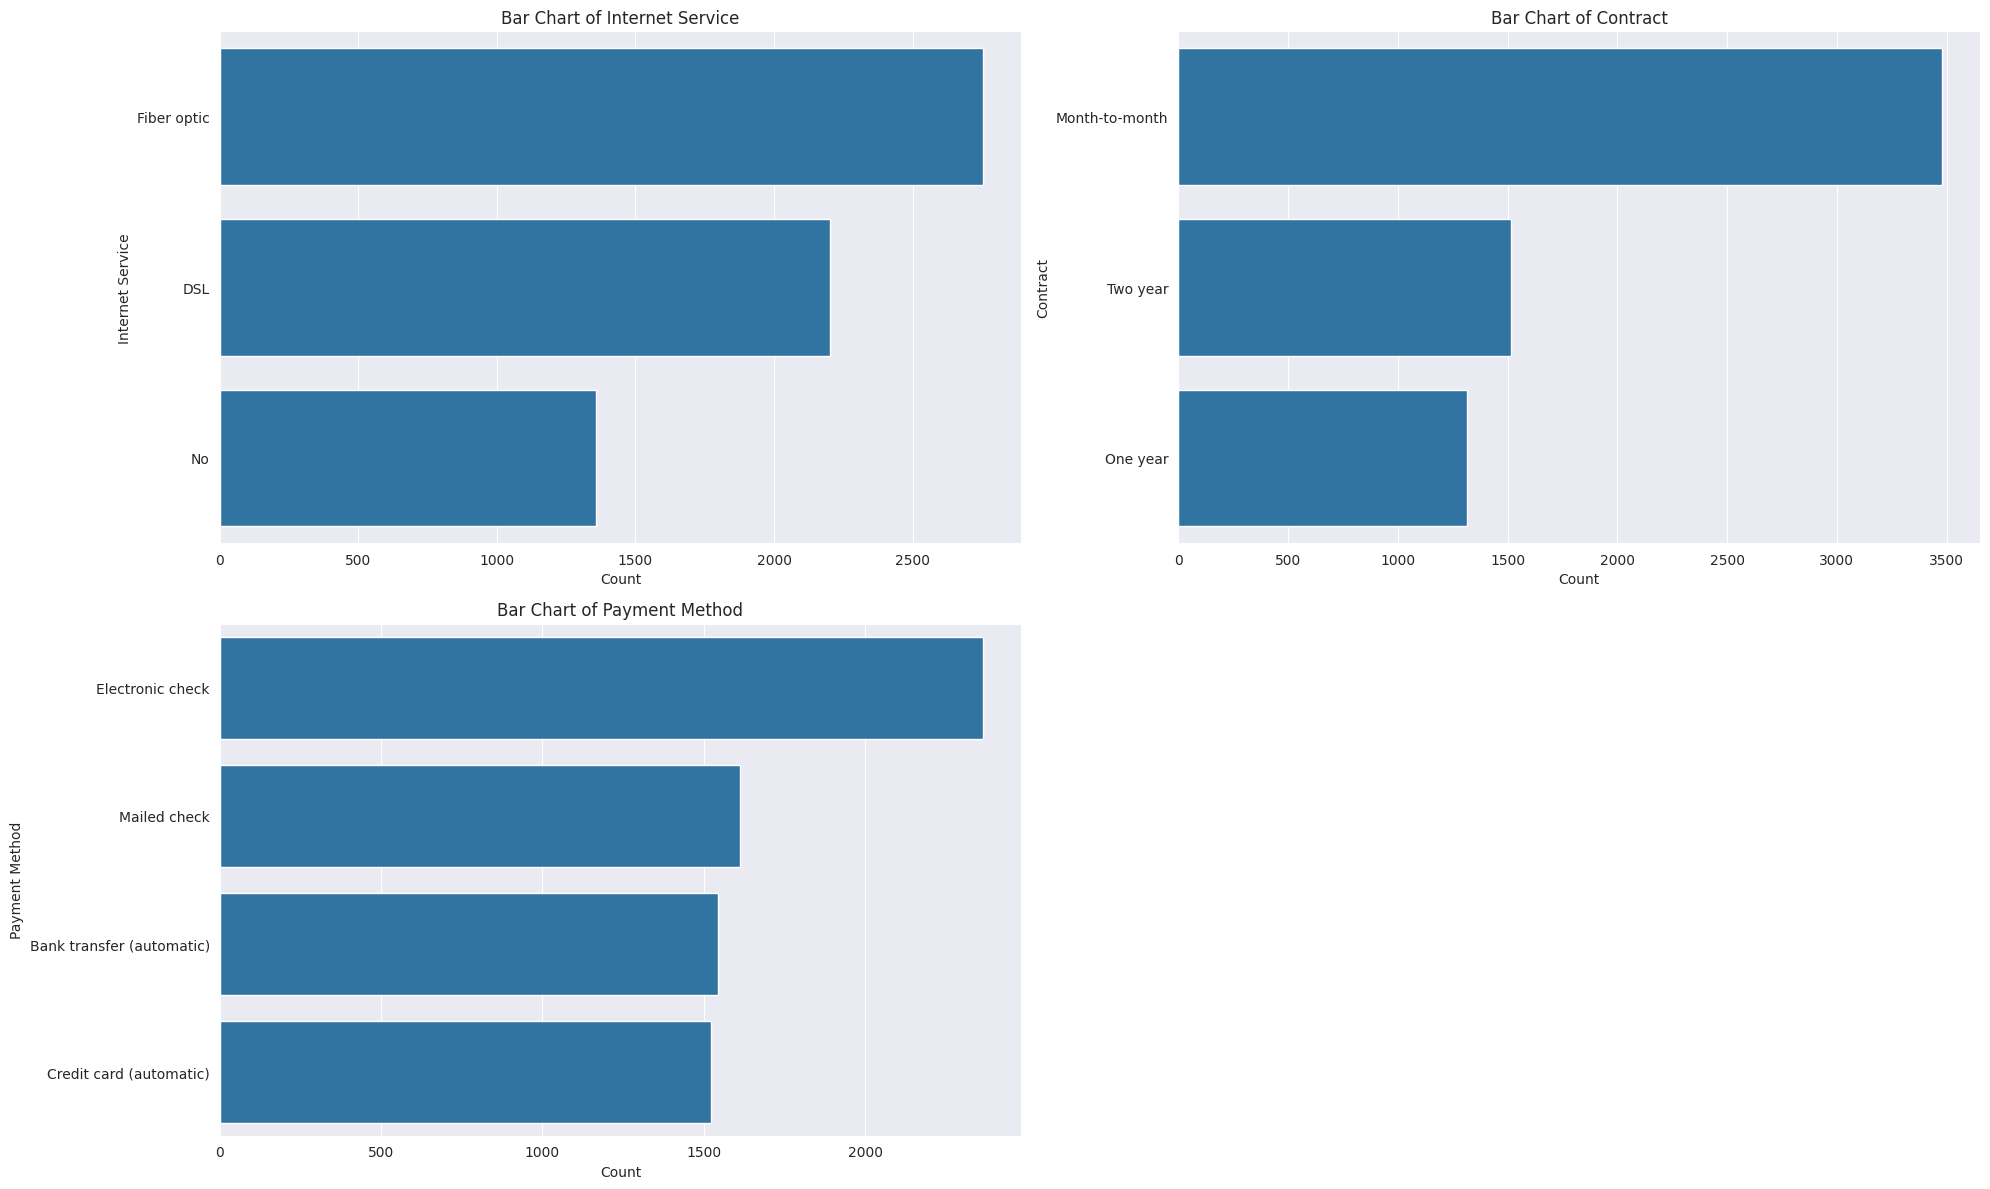

In [86]:

# Ensure the columns are numeric
df['Monthly Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')
df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Churn Score'] = pd.to_numeric(df['Churn Score'], errors='coerce')
df['CLTV'] = pd.to_numeric(df['CLTV'], errors='coerce')

# Drop rows with any NaN values in the specified columns
df_cleaned = df.dropna(subset=['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV'])

# Define the columns for which we want to create histograms
columns_to_plot = ['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV']

# Create histograms for each column
plt.figure(figsize=(20, 15))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)  # 3 rows and 2 columns for the subplots
    sb.histplot(df_cleaned[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Define the features for which we want to create bar charts
features_to_plot = ['Internet Service', 'Contract', 'Payment Method']

# Create bar charts for each feature
plt.figure(figsize=(20, 12))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)  # 2 rows and 2 columns for the subplots
    sb.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'Bar Chart of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()


1b) Korrelationsmatrix

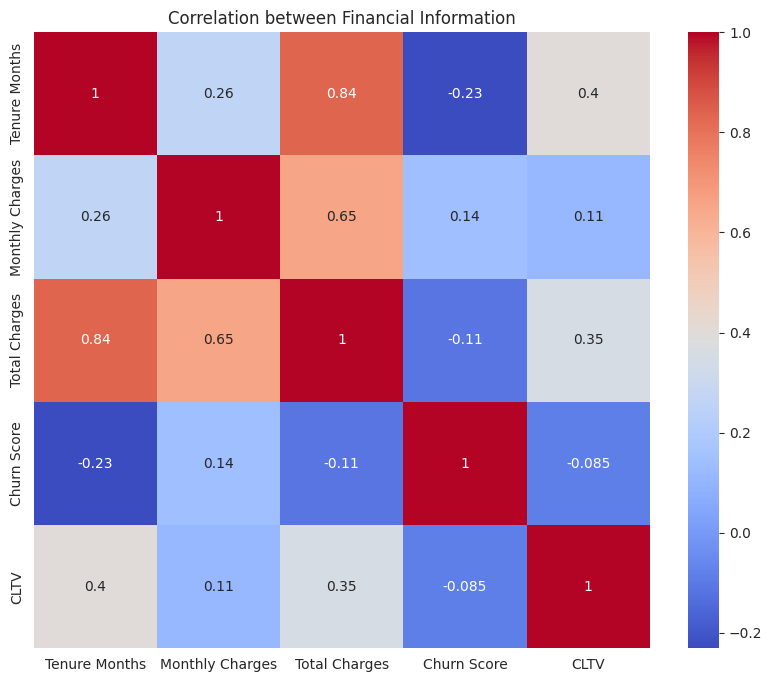

In [87]:
financial_info = df[['Tenure Months','Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']]
plt.figure(figsize=(10, 8))
sb.heatmap(financial_info.corr(), annot= True, cmap='coolwarm', square=True)
plt.title('Correlation between Financial Information')
plt.show()


Aufgabe 2

In [88]:
df.drop( ['Country','State'], axis = 1, inplace = True)
df.dropna(subset= ['Churn Score'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6137 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               5442 non-null   category
 1   Zip Code           5222 non-null   float64 
 2   Latitude           5286 non-null   object  
 3   Longitude          5578 non-null   object  
 4   Gender             6137 non-null   category
 5   Senior Citizen     6137 non-null   category
 6   Partner            6137 non-null   category
 7   Dependents         6137 non-null   category
 8   Tenure Months      5129 non-null   float64 
 9   Phone Service      6137 non-null   category
 10  Multiple Lines     6137 non-null   category
 11  Internet Service   5493 non-null   category
 12  Online Security    6137 non-null   category
 13  Online Backup      6137 non-null   category
 14  Device Protection  5127 non-null   category
 15  Tech Support       6137 non-null   category
 

In [89]:
geolocator = Photon(user_agent="geo_agent")

# Function to get address details using reverse geocoding
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location:
            address = location.raw['properties']
            city = address.get('city', address.get('town', address.get('village', None)))
            zip_code = address.get('postcode', None)
            return city, zip_code
    except Exception as e:
        print(f"Geocoding error: {e}")
    return None, None

# Function to get latitude and longitude using forward geocoding
def forward_geocode(query):
    try:
        location = geolocator.geocode(query, exactly_one=True, timeout=10)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Geocoding error: {e}")
    return None, None

# Function to fill missing values using reverse geocoding
def fill_missing_values(df):
    for index, row in df.iterrows():
        if pd.isna(row['City']) or pd.isna(row['Zip Code']):
            if not pd.isna(row['Latitude']) and not pd.isna(row['Longitude']):
                city, zip_code = reverse_geocode(row['Latitude'], row['Longitude'])
                if city:
                    if isinstance(df['City'].dtype, pd.CategoricalDtype):
                        if city not in df['City'].cat.categories:
                            df['City'] = df['City'].cat.add_categories([city])
                    df.at[index, 'City'] = city
                if zip_code:
                    df.at[index, 'Zip Code'] = zip_code
    return df

# Function to fill missing latitude and longitude using forward geocoding
def fill_missing_lat_lon(df):
    for index, row in df.iterrows():
        if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
            if not pd.isna(row['Zip Code']):
                query = f"Zip Code: {row['Zip Code']}"
            elif not pd.isna(row['City']):
                query = f"City: {row['City']}"
            else:
                continue  # No information to geocode

            lat, lon = forward_geocode(query)
            if lat and lon:
                df.at[index, 'Latitude'] = lat
                df.at[index, 'Longitude'] = lon
    return df

df_filled_lat_lon = fill_missing_lat_lon(df)
df_filled = fill_missing_values(df)

/tmp/ipykernel_6458/3455182529.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90003' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Zip Code'] = zip_code


In [90]:
def calculate_tenure(df):
    for index, row in df.iterrows():
        if pd.isna(row['Tenure Months']) or row['Tenure Months'] == "":
            if pd.notna(row['Monthly Charges']) and pd.notna(row['Total Charges']):
                try:
                    df.at[index, 'Tenure Months'] = round(float(row['Total Charges']) / float(row['Monthly Charges']))
                except (ValueError, ZeroDivisionError):
                    pass  # Handles cases where conversion fails or division by zero occurs
    return df
def calculate_monthly_charges(df):
    for index, row in df.iterrows():
        if pd.isna(row['Monthly Charges']) or row['Monthly Charges'] == "":
            if pd.notna(row['Total Charges']) and pd.notna(row['Tenure Months']):
                try:
                    df.at[index,'Monthly Charges'] = round(float(row['Total Charges']) / float(row['Tenure Months']),2)
                except (ValueError, ZeroDivisionError):
                    pass

def calculate_total_charges(df):
    for index, row in df.iterrows():
        if pd.isna(row['Total Charges']) or row['Total Charges'] == "":
            if pd.notna(row['Monthly Charges']) and pd.notna(row['Tenure Months']):
                try:
                    df.at[index,'Total Charges'] = round(float(row['Monthly Charges']) * float(row['Tenure Months']),2)
                except (ValueError, ZeroDivisionError):
                    pass
calculate_tenure(df)
calculate_monthly_charges(df)
calculate_total_charges(df)

In [91]:
df.to_csv('tenure.csv', index = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6137 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               5875 non-null   category
 1   Zip Code           5822 non-null   object  
 2   Latitude           6114 non-null   object  
 3   Longitude          6122 non-null   object  
 4   Gender             6137 non-null   category
 5   Senior Citizen     6137 non-null   category
 6   Partner            6137 non-null   category
 7   Dependents         6137 non-null   category
 8   Tenure Months      5898 non-null   float64 
 9   Phone Service      6137 non-null   category
 10  Multiple Lines     6137 non-null   category
 11  Internet Service   5493 non-null   category
 12  Online Security    6137 non-null   category
 13  Online Backup      6137 non-null   category
 14  Device Protection  5127 non-null   category
 15  Tech Support       6137 non-null   category
 

Fix Tenure Months / Charges


In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

df['Tenure Months Train'] = df['Tenure Months']
df['Total Charges Train'] = df['Total Charges']
df.reset_index(drop=True, inplace=True)

imputer = SimpleImputer(strategy='mean')
df['Total Charges Train'] = imputer.fit_transform(df[['Total Charges Train']])

dft = df[['Tenure Months Train','Total Charges Train']].dropna()
dft.columns = dft.columns.str.strip()
x_train = dft[['Total Charges Train']]
y_train = dft[['Tenure Months Train']]

model = LinearRegression()
model.fit(x_train, y_train)

missing_tenure = df['Tenure Months'].isnull()

X_missing = df.loc[missing_tenure, ['Total Charges Train']]
df.loc[missing_tenure, 'Tenure Months'] = model.predict(X_missing).round()
df.drop(columns=['Total Charges Train','Tenure Months Train'], inplace=True)




In [93]:
calculate_monthly_charges(df)
calculate_total_charges(df)
df.to_csv('tenure.csv', index = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               5875 non-null   category
 1   Zip Code           5822 non-null   object  
 2   Latitude           6114 non-null   object  
 3   Longitude          6122 non-null   object  
 4   Gender             6137 non-null   category
 5   Senior Citizen     6137 non-null   category
 6   Partner            6137 non-null   category
 7   Dependents         6137 non-null   category
 8   Tenure Months      6137 non-null   float64 
 9   Phone Service      6137 non-null   category
 10  Multiple Lines     6137 non-null   category
 11  Internet Service   5493 non-null   category
 12  Online Security    6137 non-null   category
 13  Online Backup      6137 non-null   category
 14  Device Protection  5127 non-null   category
 15  Tech Support       6137 non-null   category
 16  Stream

Use Total Charges / Tenure Months to calculate Missing Monthly Charges and Tenure Months * Monthly Charges to calculate missing Total Charges


In [94]:
df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Monthly Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')

train_df = df.dropna(subset=['Monthly Charges'])

X_train = train_df[['Tenure Months']]
y_train = train_df['Monthly Charges']

model = LinearRegression()
model.fit(X_train, y_train)

missing_mask = df['Monthly Charges'].isna()
df.loc[missing_mask, 'Monthly Charges'] = model.predict(df.loc[missing_mask, ['Tenure Months']]).round(2)
calculate_total_charges(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               5875 non-null   category
 1   Zip Code           5822 non-null   object  
 2   Latitude           6114 non-null   object  
 3   Longitude          6122 non-null   object  
 4   Gender             6137 non-null   category
 5   Senior Citizen     6137 non-null   category
 6   Partner            6137 non-null   category
 7   Dependents         6137 non-null   category
 8   Tenure Months      6137 non-null   float64 
 9   Phone Service      6137 non-null   category
 10  Multiple Lines     6137 non-null   category
 11  Internet Service   5493 non-null   category
 12  Online Security    6137 non-null   category
 13  Online Backup      6137 non-null   category
 14  Device Protection  5127 non-null   category
 15  Tech Support       6137 non-null   category
 16  Stream

Internet Service

<Axes: >

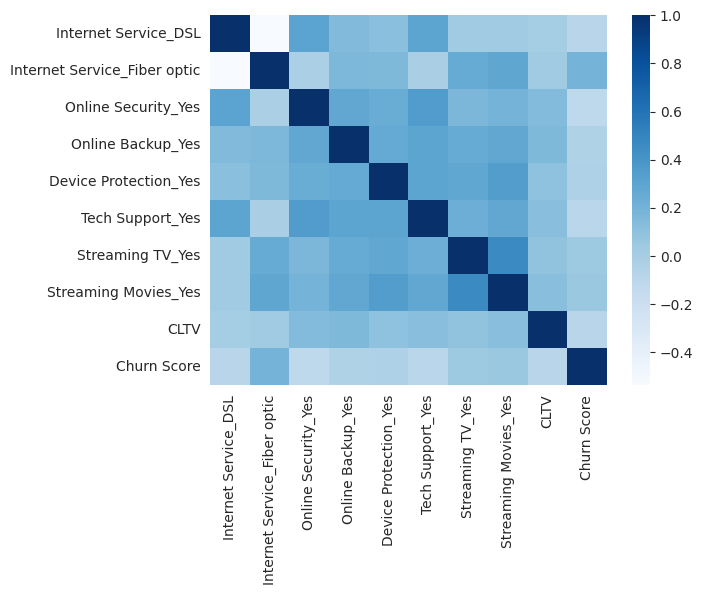

In [95]:

categorical_columns = ['Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
categorical_columns = [col for col in categorical_columns if col in df.columns]
df_encoded = pd.get_dummies(df, columns=['Internet Service'], drop_first=False)
df_encoded = pd.get_dummies(df_encoded, columns=[col for col in categorical_columns if col != 'Internet Service'], drop_first=True)
relevant_columns = [col for col in df_encoded.columns if any(cat in col for cat in categorical_columns) and '_No' not in col]
relevant_columns.append('CLTV')
relevant_columns.append('Churn Score')
df_encoded = df_encoded[relevant_columns]

correlation_matrix = df_encoded.corr(numeric_only=True)
sb.heatmap(correlation_matrix, cmap="Blues", annot=False)

In [96]:
internet_service_col = "Internet Service"
target_columns = ["Online Security", "Online Backup", "Device Protection",
                  "Tech Support", "Streaming TV", "Streaming Movies"]

mask = df[target_columns].eq("No internet service").any(axis=1)

df.loc[mask, target_columns] = "No internet service"

df.loc[mask, internet_service_col] = "No"

df.info()

df.to_csv('internet.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               5875 non-null   category
 1   Zip Code           5822 non-null   object  
 2   Latitude           6114 non-null   object  
 3   Longitude          6122 non-null   object  
 4   Gender             6137 non-null   category
 5   Senior Citizen     6137 non-null   category
 6   Partner            6137 non-null   category
 7   Dependents         6137 non-null   category
 8   Tenure Months      6137 non-null   float64 
 9   Phone Service      6137 non-null   category
 10  Multiple Lines     6137 non-null   category
 11  Internet Service   5645 non-null   category
 12  Online Security    6137 non-null   category
 13  Online Backup      6137 non-null   category
 14  Device Protection  5349 non-null   category
 15  Tech Support       6137 non-null   category
 16  Stream

In [97]:
mask = df['Streaming TV'].isna()
random_values = np.random.choice(['No', 'Yes'], size=mask.sum())
df.loc[mask, 'Streaming TV'] = random_values

mask = df['Device Protection'].isna()
random_values = np.random.choice(['No', 'Yes'], size=mask.sum())
df.loc[mask, 'Device Protection'] = random_values

In [98]:
df.info()
df.to_csv('telco2.csv', index = False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   City               5875 non-null   category
 1   Zip Code           5822 non-null   object  
 2   Latitude           6114 non-null   object  
 3   Longitude          6122 non-null   object  
 4   Gender             6137 non-null   category
 5   Senior Citizen     6137 non-null   category
 6   Partner            6137 non-null   category
 7   Dependents         6137 non-null   category
 8   Tenure Months      6137 non-null   float64 
 9   Phone Service      6137 non-null   category
 10  Multiple Lines     6137 non-null   category
 11  Internet Service   5645 non-null   category
 12  Online Security    6137 non-null   category
 13  Online Backup      6137 non-null   category
 14  Device Protection  6137 non-null   category
 15  Tech Support       6137 non-null   category
 16  Stream

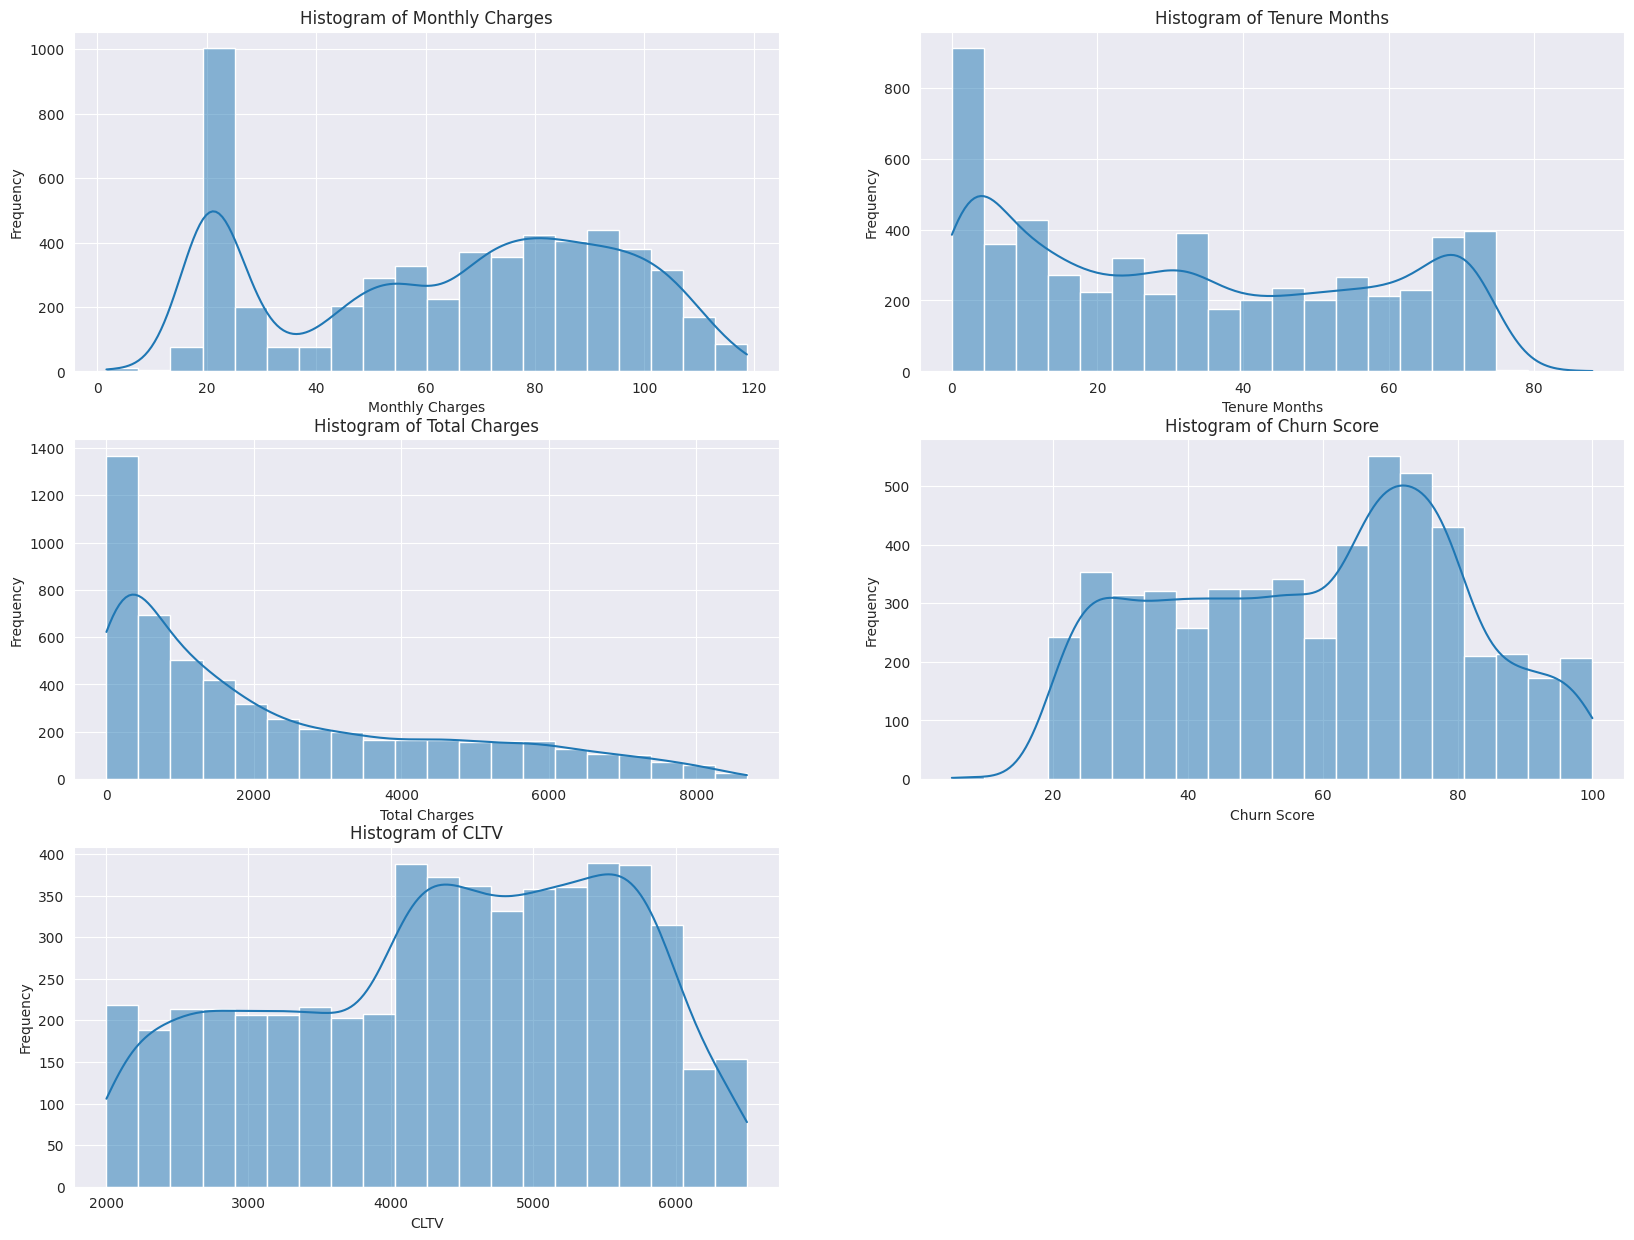

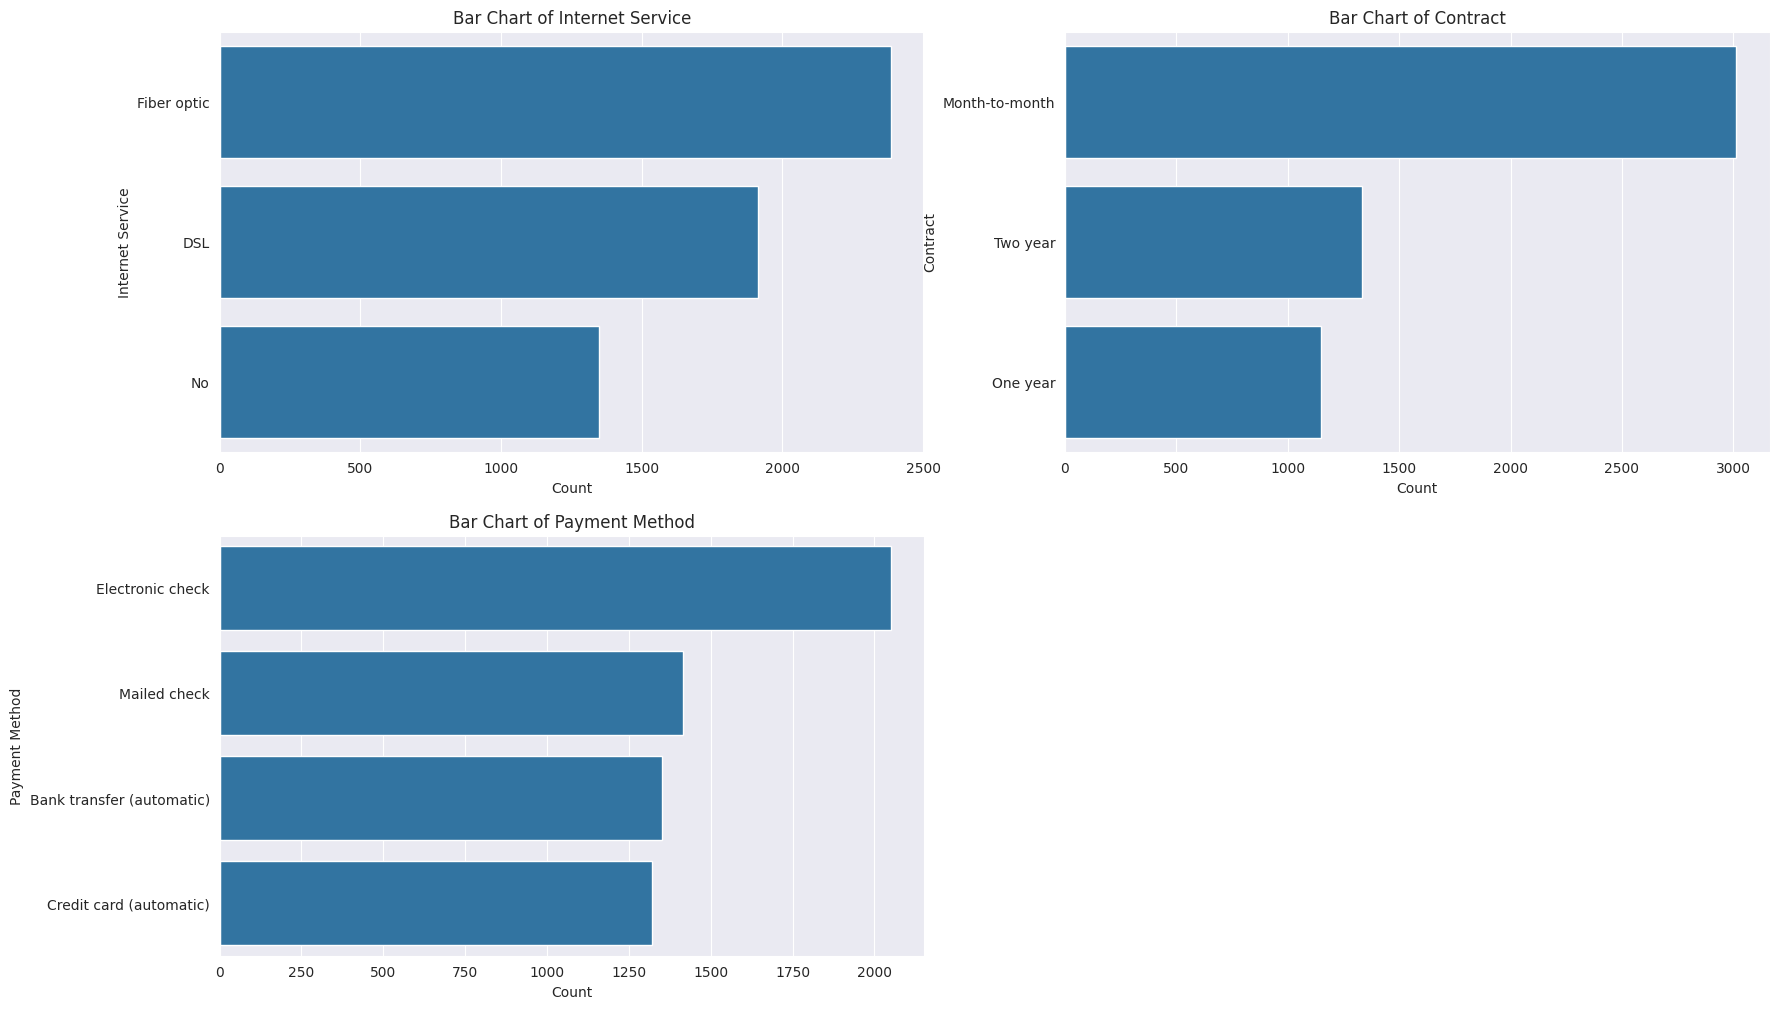

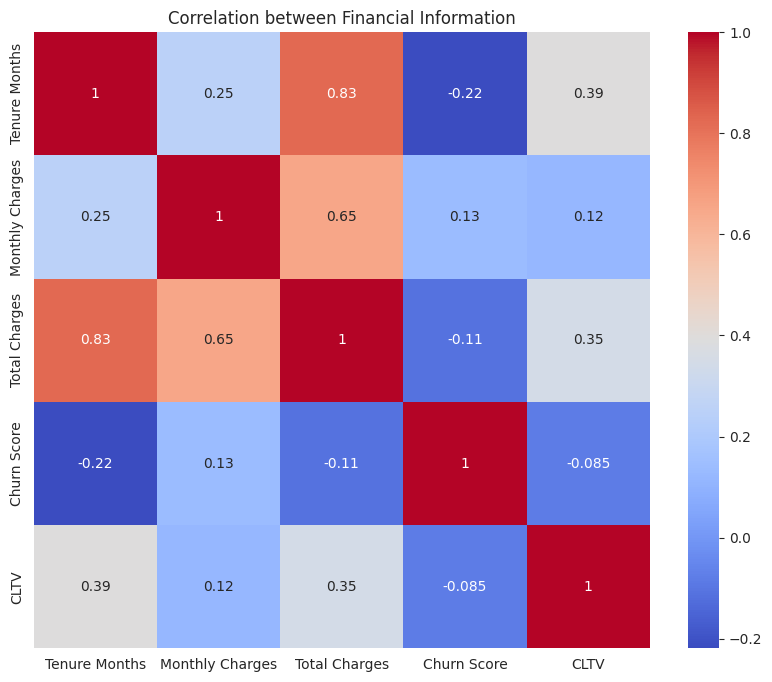

In [99]:

# Ensure the columns are numeric
df['Monthly Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')
df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Churn Score'] = pd.to_numeric(df['Churn Score'], errors='coerce')
df['CLTV'] = pd.to_numeric(df['CLTV'], errors='coerce')

# Drop rows with any NaN values in the specified columns
df_cleaned = df.dropna(subset=['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV'])

# Define the columns for which we want to create histograms
columns_to_plot = ['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Score', 'CLTV']

# Create histograms for each column
plt.figure(figsize=(20, 15))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)  # 3 rows and 2 columns for the subplots
    sb.histplot(df_cleaned[column], bins=20, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Define the features for which we want to create bar charts
features_to_plot = ['Internet Service', 'Contract', 'Payment Method']

# Create bar charts for each feature
plt.figure(figsize=(20, 12))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)  # 2 rows and 2 columns for the subplots
    sb.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.title(f'Bar Chart of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)


financial_info = df[['Tenure Months','Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']]
plt.figure(figsize=(10, 8))
sb.heatmap(financial_info.corr(), annot= True, cmap='coolwarm', square=True)
plt.title('Correlation between Financial Information')
plt.show()